# HMS SQLite Grid Database Operations

HEC-HMS 4.x gridded models (Modified Clark, SCS Grid) store authoritative spatial geometry
in SQLite databases rather than `.geo`/`.map` text files. This notebook demonstrates how to
extract subbasin polygons, CRS information, and layer metadata from these databases using
`HmsSqlite`.

## What You'll Learn

- Detect whether an HMS project is gridded or lumped
- List spatial layers and their row counts from a SQLite database
- Extract CRS (coordinate reference system) information
- Read subbasin polygons as GeoDataFrames and visualize them
- Handle empty tables gracefully (common in gridded models)
- Read all layers in a single call with `read_grid_database()`
- Compare geometry across multiple basin model databases
- Use `init_hms_project()` to auto-detect gridded models and CRS

## Prerequisites

- HEC-HMS 4.x installed (for bundled `river_bend` example project)
- `pip install hms-commander[gis]` (geopandas for geometry operations)

In [1]:
# pip install hms-commander[gis]

**For Development**: If working on hms-commander source code, use the `hmscmdr_local`
conda environment (editable install) instead of pip install.

## Example 1: Single Database Walkthrough

The `river_bend` example project ships with every HMS 4.x installation and contains
three SQLite grid databases (one per basin model scenario). We start with a detailed
walkthrough of a single database.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger('hms_commander').setLevel(logging.WARNING)

from pathlib import Path
import matplotlib.pyplot as plt
from hms_commander import HmsExamples, HmsSqlite, HmsGeo, init_hms_project

# Extract the river_bend example project (ships with HMS 4.x)
HmsExamples.extract_project("river_bend")
project_dir = Path("hms_example_projects/river_bend")
print(f"Project directory: {project_dir}")

Project directory: hms_example_projects\river_bend


### Detect Model Type

`HmsGeo.detect_model_type()` checks for `.sqlite` files to classify the model.

In [3]:
model_type = HmsGeo.detect_model_type(project_dir)
print(f"Model type: {model_type}")

sqlite_files = HmsSqlite.discover_sqlite_files(project_dir)
print(f"\nSQLite databases found: {len(sqlite_files)}")
for f in sqlite_files:
    print(f"  {f.name} ({f.stat().st_size / 1024:.0f} KB)")

Model type: gridded

SQLite databases found: 3
  Minimum_Facility.sqlite (18 KB)
  Minimum_Facility_+_4Pumps.sqlite (18 KB)
  Minimum_Facility_+_Pump.sqlite (18 KB)


### List Layers (No geopandas Required)

`list_layers()` and `get_crs()` use stdlib `sqlite3` only — they work even without
geopandas installed.

In [4]:
sqlite_file = sqlite_files[0]  # Minimum_Facility.sqlite
print(f"Inspecting: {sqlite_file.name}\n")

layers = HmsSqlite.list_layers(sqlite_file)
print(layers.to_string(index=False))

print(f"\nNon-empty layers: {layers[layers['row_count'] > 0]['table_name'].tolist()}")

Inspecting: Minimum_Facility.sqlite

 table_name  row_count geometry_type  srid
  diversion          0         Point 26916
   junction          0         Point 26916
      reach          0    LineString 26916
    reach2d          0    LineString 26916
  reservoir          0         Point 26916
reservoir2d          0  MultiPolygon 26916
       sink          0         Point 26916
     source          0         Point 26916
   subbasin          0         Point 26916
 subbasin2d          2  MultiPolygon 26916

Non-empty layers: ['subbasin2d']


### Extract CRS

In [5]:
wkt = HmsSqlite.get_crs(sqlite_file)
proj_name = wkt.split('"')[1] if wkt else "Unknown"
print(f"CRS: {proj_name}")
print(f"WKT length: {len(wkt)} characters")
print(f"First 120 chars: {wkt[:120]}...")

CRS: NAD83 / UTM zone 16N
WKT length: 638 characters
First 120 chars: PROJCS["NAD83 / UTM zone 16N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101...


### Read Subbasin Polygons

In [6]:
subbasins = HmsSqlite.get_subbasins(sqlite_file)
print(f"Subbasins: {len(subbasins)}")
print(f"CRS: {subbasins.crs}")
print(f"Geometry types: {subbasins.geom_type.unique().tolist()}")
print(f"Subbasin names: {subbasins['name'].tolist()}")

# Compute area from geometry (CRS is projected in meters)
subbasins['computed_area_m2'] = subbasins.geometry.area
subbasins['computed_area_ha'] = subbasins['computed_area_m2'] / 10_000
print(f"\nComputed areas (from polygon geometry):")
for _, row in subbasins.iterrows():
    print(f"  {row['name']}: {row['computed_area_m2']:,.0f} m\u00b2 ({row['computed_area_ha']:.1f} ha)")

Subbasins: 2
CRS: EPSG:26916
Geometry types: ['Polygon']
Subbasin names: ['Upper', 'Local']

Computed areas (from polygon geometry):
  Upper: 225,216 m² (22.5 ha)
  Local: 157,585 m² (15.8 ha)


### Figure 1: Subbasin Map with Computed Areas

Since the CRS is projected (NAD83 / UTM zone 16N, units = meters), we can compute
areas directly from the polygon geometry.

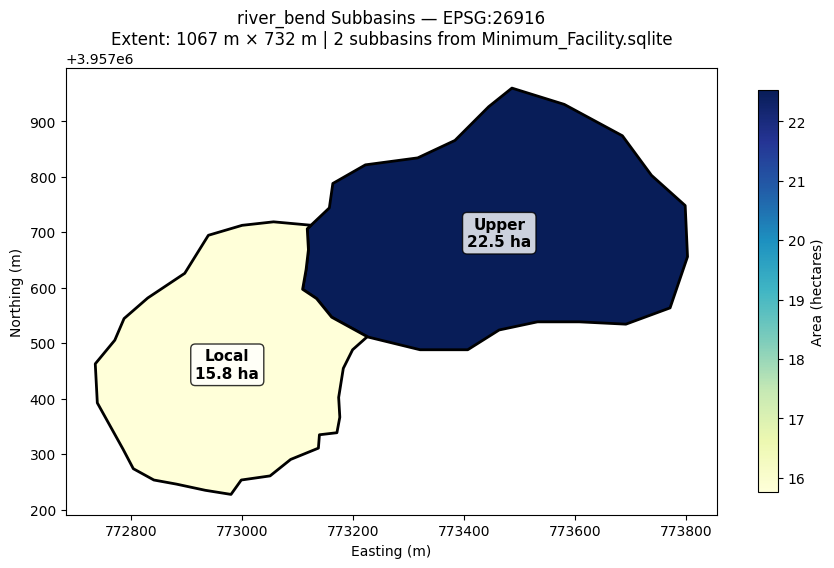

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))

subbasins.plot(
    ax=ax, column='computed_area_ha', cmap='YlGnBu',
    edgecolor='black', linewidth=2, legend=True,
    legend_kwds={'label': 'Area (hectares)', 'shrink': 0.6}
)

for _, row in subbasins.iterrows():
    centroid = row.geometry.centroid
    label = f"{row['name']}\n{row['computed_area_ha']:.1f} ha"
    ax.annotate(
        label, xy=(centroid.x, centroid.y),
        ha='center', va='center', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8)
    )

bounds = subbasins.total_bounds
width_m = bounds[2] - bounds[0]
height_m = bounds[3] - bounds[1]

ax.set_title(
    f'river_bend Subbasins \u2014 {subbasins.crs}\n'
    f'Extent: {width_m:.0f} m \u00d7 {height_m:.0f} m | '
    f'{len(subbasins)} subbasins from {sqlite_file.name}',
    fontsize=12
)
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.ticklabel_format(style='plain', axis='both')
plt.tight_layout()
plt.show()

### Handle Empty Tables Gracefully

Gridded models often have empty `junction`, `reach`, and `subbasin` (1D) tables.
The 2D geometry lives in `subbasin2d` and `reach2d` instead.
`HmsSqlite` returns empty GeoDataFrames with the correct CRS.

In [8]:
for _, layer_row in layers.iterrows():
    name = layer_row['table_name']
    count = layer_row['row_count']
    status = f"{count} features" if count > 0 else "empty"
    marker = "\u2705" if count > 0 else "\u2014"
    print(f"  {marker} {name}: {status}")

  — diversion: empty
  — junction: empty
  — reach: empty
  — reach2d: empty
  — reservoir: empty
  — reservoir2d: empty
  — sink: empty
  — source: empty
  — subbasin: empty
  ✅ subbasin2d: 2 features


### Read All Layers at Once

`read_grid_database()` reads all layers in one call. Use `skip_empty=True`
(default) to omit empty tables.

In [9]:
all_layers = HmsSqlite.read_grid_database(sqlite_file, skip_empty=True)

print(f"Layers with data: {len(all_layers)}")
for name, gdf in all_layers.items():
    geom_type = gdf.geom_type.iloc[0] if len(gdf) > 0 else 'empty'
    print(f"  {name}: {len(gdf)} features ({geom_type})")

Layers with data: 1
  subbasin2d: 2 features (Polygon)


## Example 2: Comparing Multiple Basin Model Databases

river_bend has three SQLite databases \u2014 one per basin model scenario
(Minimum Facility, + Pump, + 4 Pumps). This demonstrates reading and
comparing geometry across multiple databases, plus project initialization.

### Figure 2: Side-by-Side Basin Model Comparison

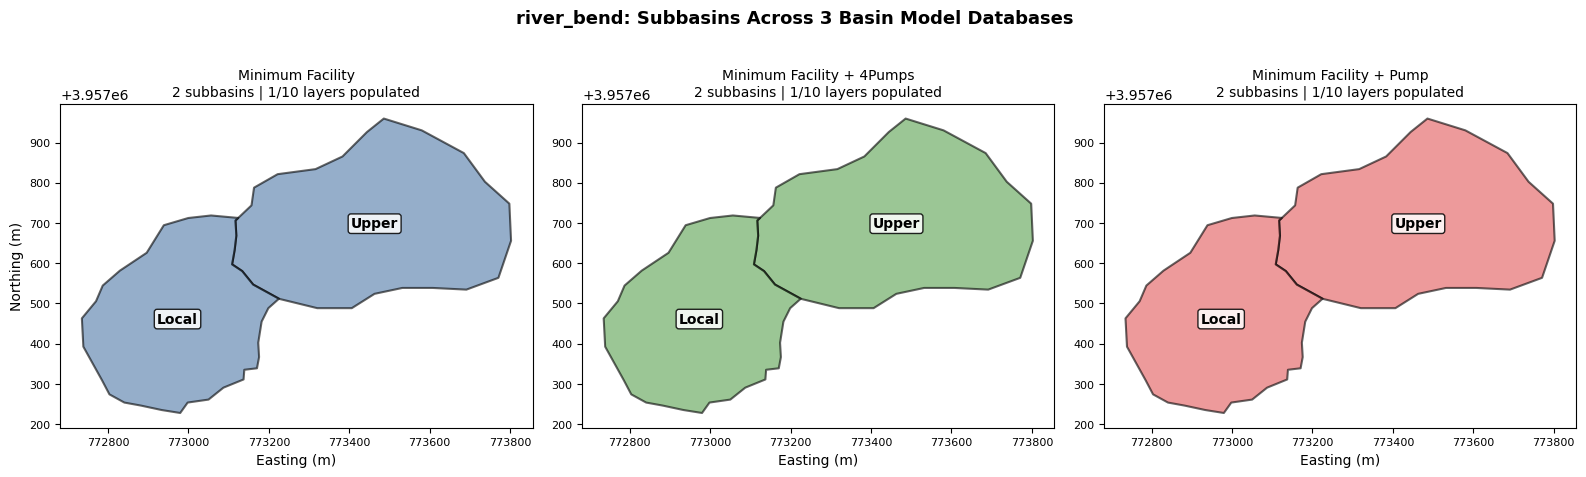

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

colors = ['#4e79a7', '#59a14f', '#e15759']

for i, (sqlite_f, color) in enumerate(zip(sqlite_files, colors)):
    ax = axes[i]
    subs = HmsSqlite.get_subbasins(sqlite_f)
    layer_info = HmsSqlite.list_layers(sqlite_f)

    subs.plot(ax=ax, facecolor=color, edgecolor='black', linewidth=1.5, alpha=0.6)

    for _, row in subs.iterrows():
        centroid = row.geometry.centroid
        ax.annotate(
            row['name'], xy=(centroid.x, centroid.y),
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.85)
        )

    n_with_data = (layer_info['row_count'] > 0).sum()
    title = sqlite_f.stem.replace('_', ' ')
    ax.set_title(f'{title}\n{len(subs)} subbasins | {n_with_data}/{len(layer_info)} layers populated', fontsize=10)
    ax.set_xlabel('Easting (m)')
    if i == 0:
        ax.set_ylabel('Northing (m)')
    ax.ticklabel_format(style='plain', axis='both')
    ax.tick_params(labelsize=8)

fig.suptitle('river_bend: Subbasins Across 3 Basin Model Databases', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### Project Initialization Integration

`init_hms_project()` automatically discovers SQLite files, sets `is_gridded`, and
detects CRS from the `spatial_ref_sys` table.

In [11]:
hms = init_hms_project(project_dir)

print(f"Project:      {hms.project_name}")
print(f"HMS Version:  {hms.hms_version}")
print(f"Gridded:      {hms.is_gridded}")
print(f"SQLite files: {len(hms.sqlite_files)}")
print(f"CRS EPSG:     {hms.crs_epsg}")
print(f"CRS name:     {hms.crs.name if hms.crs else 'None'}")
print(f"Basin models: {len(hms.basin_df)}")
print(f"Runs:         {len(hms.run_df)}")

Project:      river_bend
HMS Version:  4.13
Gridded:      True
SQLite files: 3
CRS EPSG:     EPSG:26916
CRS name:     NAD83 / UTM zone 16N
Basin models: 3
Runs:         3


### Figure 3: Summary Dashboard

Combine subbasin geometry, layer inventory, and project metadata in a single figure.

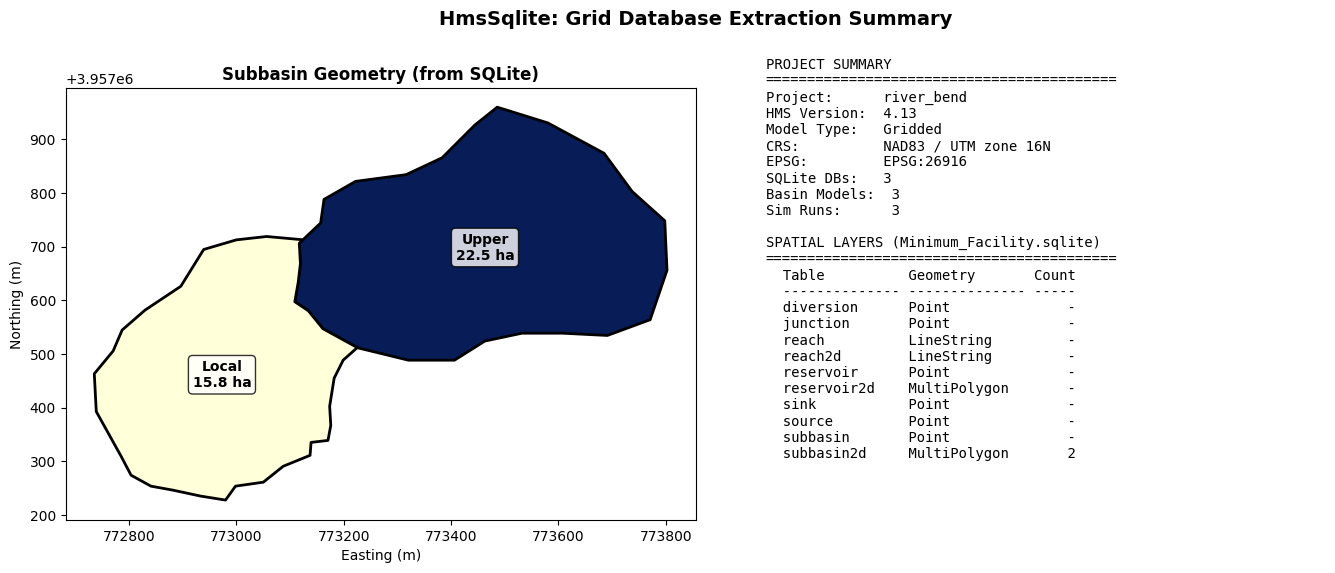

In [12]:
fig = plt.figure(figsize=(14, 6))

# Left panel: subbasin map
ax_map = fig.add_axes([0.05, 0.08, 0.45, 0.82])
subbasins.plot(
    ax=ax_map, column='computed_area_ha', cmap='YlGnBu',
    edgecolor='black', linewidth=2
)
for _, row in subbasins.iterrows():
    c = row.geometry.centroid
    ax_map.annotate(
        f"{row['name']}\n{row['computed_area_ha']:.1f} ha",
        xy=(c.x, c.y), ha='center', va='center', fontsize=10, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8)
    )
ax_map.set_title('Subbasin Geometry (from SQLite)', fontsize=12, fontweight='bold')
ax_map.set_xlabel('Easting (m)')
ax_map.set_ylabel('Northing (m)')
ax_map.ticklabel_format(style='plain', axis='both')

# Right panel: text summary
ax_text = fig.add_axes([0.55, 0.08, 0.40, 0.82])
ax_text.axis('off')

layer_summary = []
for _, lr in layers.iterrows():
    status = f"{lr['row_count']:>5}" if lr['row_count'] > 0 else "    -"
    layer_summary.append(f"  {lr['table_name']:<14} {lr['geometry_type']:<14} {status}")

summary = (
    f"PROJECT SUMMARY\n"
    f"{'='*42}\n"
    f"Project:      {hms.project_name}\n"
    f"HMS Version:  {hms.hms_version}\n"
    f"Model Type:   {'Gridded' if hms.is_gridded else 'Lumped'}\n"
    f"CRS:          {hms.crs.name if hms.crs else 'Unknown'}\n"
    f"EPSG:         {hms.crs_epsg}\n"
    f"SQLite DBs:   {len(hms.sqlite_files)}\n"
    f"Basin Models:  {len(hms.basin_df)}\n"
    f"Sim Runs:      {len(hms.run_df)}\n"
    f"\nSPATIAL LAYERS ({sqlite_file.name})\n"
    f"{'='*42}\n"
    f"  {'Table':<14} {'Geometry':<14} {'Count':>5}\n"
    f"  {'-'*14} {'-'*14} {'-'*5}\n"
    + "\n".join(layer_summary)
)

ax_text.text(
    0.0, 1.0, summary, transform=ax_text.transAxes,
    fontsize=10, fontfamily='monospace', verticalalignment='top'
)

fig.suptitle(
    'HmsSqlite: Grid Database Extraction Summary',
    fontsize=14, fontweight='bold', y=0.98
)
plt.show()

## Key Takeaways

- **`HmsGeo.detect_model_type()`** checks for `.sqlite` files to classify gridded vs lumped models
- **`HmsSqlite.list_layers()`** and **`get_crs()`** use stdlib `sqlite3` only (no geopandas needed)
- **`get_subbasins()`**, **`get_reaches()`**, **`get_outlets()`** return GeoDataFrames with CRS
- Empty tables (common: `junction`, `reach`, `subbasin`) return empty GeoDataFrames gracefully
- **`read_grid_database()`** reads all layers in one call, with `skip_empty=True` by default
- **`init_hms_project()`** automatically discovers SQLite files and sets `is_gridded` + CRS
- The `discretization` layer (grid cells) can be very large \u2014 use `include_discretization=True` only when needed

## Adapting for Your Project

```python
from hms_commander import HmsSqlite, HmsGeo, init_hms_project

# Check if your project is gridded
model_type = HmsGeo.detect_model_type("path/to/hms/project")

if model_type == "gridded":
    # Find and read SQLite databases
    sqlite_files = HmsSqlite.discover_sqlite_files("path/to/hms/project")
    subbasins = HmsSqlite.get_subbasins(sqlite_files[0])
    reaches = HmsSqlite.get_reaches(sqlite_files[0])
    
    # Or read everything at once
    all_layers = HmsSqlite.read_grid_database(sqlite_files[0])
else:
    # Use HmsGeo for lumped models (.geo/.map files)
    coords = HmsGeo.parse_geo_file("project.geo")
```